In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7, VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2 
from sklearn.metrics import classification_report, confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
#drive.mount("/content/drive/", force_remount=True)


In [ ]:
X_val=[]
y_val=[]
X_train = []
y_train = []
image_size = 224
labels = ['Tomato___Bacterial_spot','Tomato___Late_blight','Tomato___Septoria_leaf_spot',
           'Tomato___Early_blight','Tomato___Leaf_Mold','Tomato___Target_Spot',
          'Tomato___healthy','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus',
          'Tomato___Spider_mites Two-spotted_spider_mite']
for i in labels:
    folderPath = os.path.join('/kaggle/input/tomatoleaf/tomato/train',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        # img = 1.jpg
        img = cv2.resize(img,(image_size, image_size))
        # img = [[[],[]],[[],[]]] like 3d
        X_train.append(img)
        y_train.append(i)
X_train = np.array(X_train)
# converted list to numpy array for better compilation
y_train = np.array(y_train)

for i in labels:
    folderPath = os.path.join('/kaggle/input/tomatoleaf/tomato/val',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        # img = 1.jpg
        img = cv2.resize(img,(image_size, image_size))
        # img = [[[],[]],[[],[]]] like 3d
        X_val.append(img)
        y_val.append(i)
X_val = np.array(X_val)
y_val = np.array(y_val)

In [4]:
classes=['Tomato___Bacterial_spot','Tomato___Late_blight','Tomato___Septoria_leaf_spot',
           'Tomato___Early_blight','Tomato___Leaf_Mold','Tomato___Target_Spot',
          'Tomato___healthy','Tomato___Tomato_Yellow_Leaf_Curl_Virus','Tomato___Tomato_mosaic_virus',
          'Tomato___Spider_mites Two-spotted_spider_mite']

In [ ]:
# It shuffle like card 
X_train,y_train=shuffle(X_train,y_train,random_state=42)

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=.2,random_state=42)


In [ ]:
# for train
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
# y_train for tocategorical model train
# tocategorical convert string label to numeric
y_train = tf.keras.utils.to_categorical(y_train)

# for test
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))

y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

In [ ]:
images_dict = dict()
x_train_dict = dict()

# enumerate contains key, value, i is key and l is value like 'healthy'
for i, l in enumerate(y_train_new):
  if len(images_dict) == 10:
    # when image dictionary get 10 class then it will break
    # it will take 1 data from every class for test to predict that is it true or false
    break
  if l not in images_dict.keys():
    x_train_dict[l] = X_train[i]
    images_dict[l] = X_train[i].reshape((224, 224,3))

# sorting image dictionary
images_dict = dict(sorted(images_dict.items()))

# x_train sort the dictionary then it sort each each class
x_trian_each_class = [x_train_dict[i] for i in sorted(x_train_dict)]
# converted class to numpy array cause array can predict 
x_train_each_class = np.asarray(x_trian_each_class)

# example image for each class for test set
X_test_dict = dict()
for i, l in enumerate(y_test_new):
  if len(X_test_dict)==10:
    break
  if l not in X_test_dict.keys():
    X_test_dict[l] = X_test[i]

# order by class
x_test_each_class = [X_test_dict[i] for i in sorted(X_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

In [9]:
def plot_sample(x,y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(x[index])
  plt.xlabel(classes[y[index]])

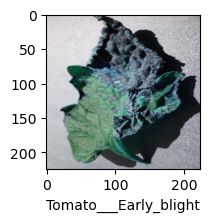

In [10]:
plot_sample(X_train,y_train_new,0)

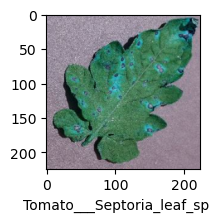

In [11]:
plot_sample(X_train,y_train_new,6)


# **custom Resnet50 + MobileNetV2 merge model**

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50,MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Concatenate, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2 

num_classes=10
base_model_resnet50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model_mobileV2 = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze layers in pre-trained models
for layer in base_model_resnet50.layers[:32]:
    layer.trainable = False
for layer in base_model_mobileV2.layers:
    layer.trainable = False

    
# Custom layers for ResNet50
custom_layers_resnet = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal',kernel_regularizer=l2(3.648937609249442e-05)),
    tf.keras.layers.Dropout(0.02203784865764158),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal',kernel_regularizer=l2(3.648937609249442e-05))
])

# Custom layers for VGG16
custom_layers_mobileV2 = tf.keras.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal',kernel_regularizer=l2(3.648937609249442e-05)),
    tf.keras.layers.Dropout(0.02203784865764158),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal',kernel_regularizer=l2(3.648937609249442e-05))
])


model_resnet = tf.keras.Sequential([base_model_resnet50, custom_layers_resnet])
model_mobileV2 = tf.keras.Sequential([base_model_vgg16, custom_layers_mobileV2])
concatenated = tf.keras.layers.Concatenate()([model_resnet.output, model_mobileV2.output])
concatenated = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(3.648937609249442e-05))(concatenated)
concatenated = tf.keras.layers.Dropout(0.02203784865764158)(concatenated)
concatenated = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(3.648937609249442e-05))(concatenated)
output=tf.keras.layers.Dense(num_classes, activation='softmax')


merged_model = tf.keras.Model(inputs=[model_resnet.input, model_mobileV2.input], outputs=output(concatenated))
merged_model.compile(optimizer=Adam(learning_rate=7.414965885327036e-05), loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir='./logs')
checkpoint = ModelCheckpoint(filepath='./best_model.h5', save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

datagen = ImageDataGenerator(
    rotation_range=20,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Train the merged model
history = merged_model.fit(
    datagen.flow([X_train, X_train], y_train, batch_size=64),
    steps_per_epoch=len(X_train) // 64,
    validation_data=([X_val, X_val], y_val),
    epochs=15,  # Increase the number of epochs
    verbose=1,
    callbacks=[tensorboard, checkpoint, reduce_lr, early_stopping]
)
merged_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/15
125/125 [==============================] - 188s 1s/step - loss: 0.6814 - accuracy: 0.8171 - val_loss: 0.3599 - val_accuracy: 0.9000 - lr: 7.4150e-05
Epoch 2/15
125/125 [==============================] - 129s 1s/step - loss: 0.1560 - accuracy: 0.9762 - val_loss: 0.1916 - val_accuracy: 0.9700 - lr: 7.4150e-05
Epoch 3/15
125/125 [==============================] - 129s 1s/step - loss: 0.1244 - accuracy: 0.9868 - val_loss: 0.1563 - val_accuracy: 0.9740 - lr: 7.4150e-05
Epoch 4/15
125/125 [==============================] - 126s 1s/step - loss: 0.1030 - accuracy: 0.9937 - val_loss: 0.2363 - val_accuracy: 0.9490 - lr: 7.4150e-05
Epoch 5/15
125/125 [==============================] - 129s 1s/step - loss: 0.0998 - accuracy: 0.9921 - val_loss: 0.1348 - val_accuracy: 0.9820 - lr: 7.4150e-05
Epoch 6/15
125/125 [==============================] - 126s 1s/step - loss: 0.1000 - accuracy: 0.9930 - val_loss: 0.1858 - val_accuracy: 0

# **Extras**

63/63 [==============================] - 7s 117ms/step
Accuracy: 0.9835
Precision: 0.9845435373392577
Recall: 0.9835
F1 Score: 0.983653586365326


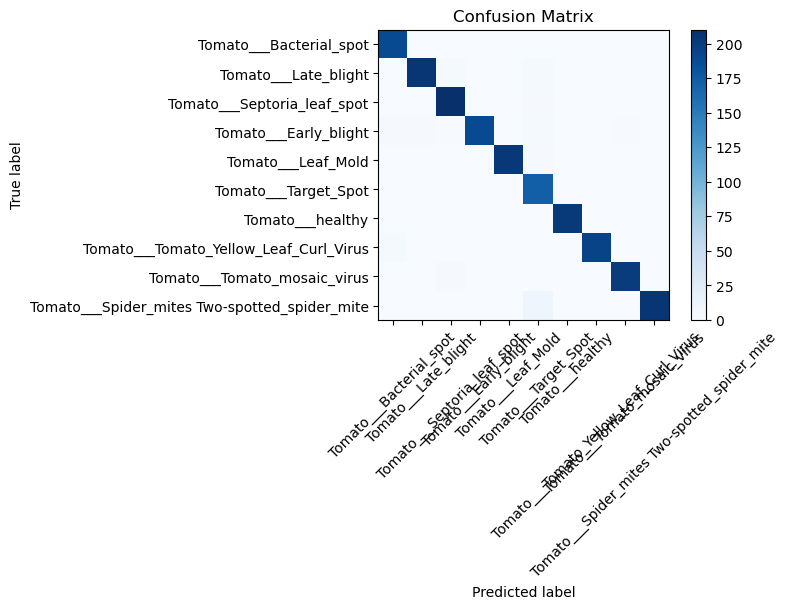

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import precision_recall_curve, average_precision_score



y_pred = merged_model.predict([X_test, X_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


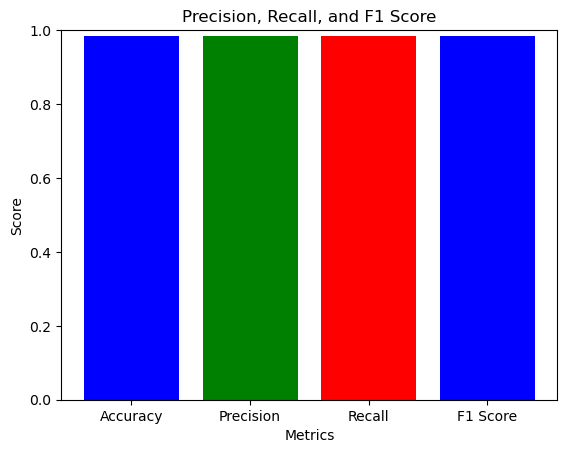

In [34]:
metrics = ['Accuracy','Precision', 'Recall', 'F1 Score']
values = [accuracy,precision, recall, f1]

plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score')
plt.ylim(0, 1)  # Set the y-axis range from 0 to 1
plt.show()

Test Accuracy: 0.9835


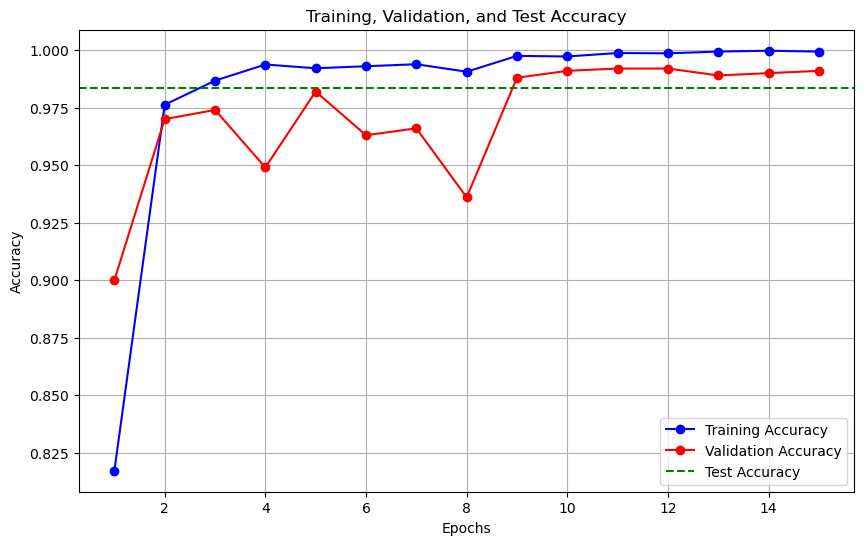

In [39]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Evaluate the model on the test set
test_loss, test_accuracy = merged_model.evaluate([X_test, X_test],y_test, verbose=0)
print(f'Test Accuracy: {test_accuracy:.4f}')

epochs = range(1, len(training_accuracy) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

63/63 [==============================] - 7s 117ms/step


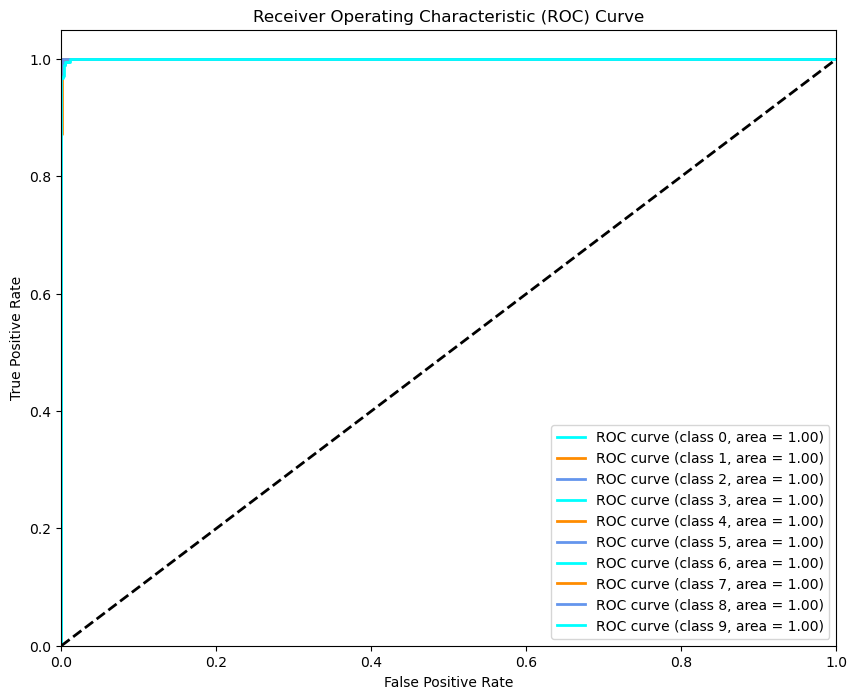

In [28]:
# Plot ROC curve for each class (one-vs-all)
n_classes = len(classes)
y_true_bin = label_binarize(y_true_classes, classes=np.arange(n_classes))
y_score = merged_model.predict([X_test, X_test])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

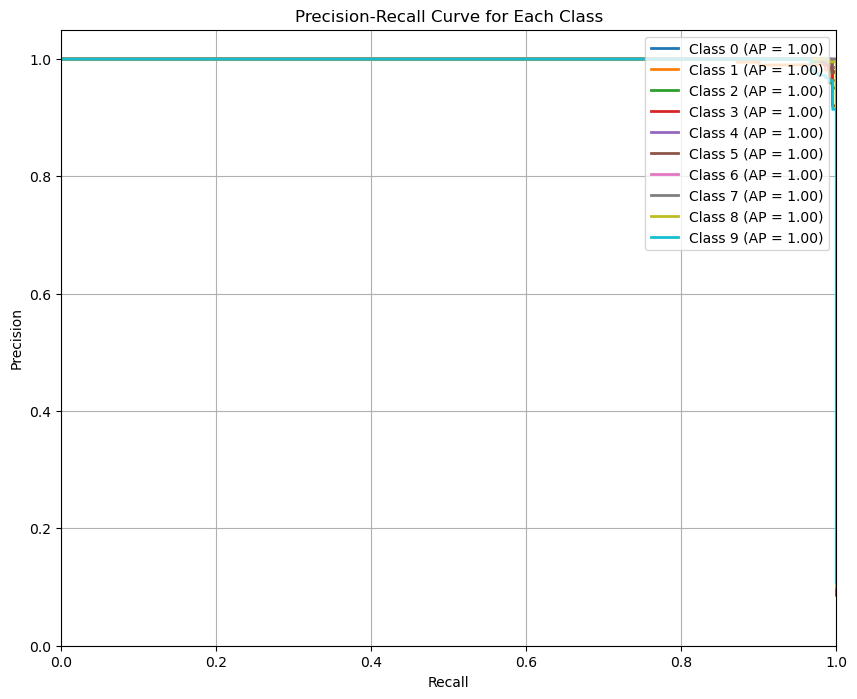

In [29]:
n_classes = y_pred.shape[1]
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

    
# Plot precision and recall vs threshold for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="upper right")
plt.grid()
plt.show()
